In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from PIL import Image
from torchvision import datasets, models
import torchvision.datasets.mnist as mnist
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
from torch.nn.modules.activation import LeakyReLU

cudnn.benchmark = True
plt.ion()
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

from torchvision.datasets import MNIST

Using cuda for inference


In [82]:
data_train = MNIST('~/mnist_data', train=True, download=True, transform = transforms.Normalize(0,1))

train_dataset = torch.utils.data.TensorDataset(data_train.train_data, torch.ones(60000))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                             shuffle=True, num_workers=4)

In [83]:
#Input size 128x1
#Output size 28x28

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(128, 512, 3, bias = False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(512, 256, 3, stride = 2, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(256, 128, 2, stride = 2, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(128, 1, 2, stride = 2, bias = False),
        nn.Tanh()
    )

  def forward(self, input):
    return self.main(input)

In [84]:
gen = Generator().to(device)
input = torch.randn(1,128,1,1,device = device)

In [85]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size = 4, stride = 2, bias = False),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(32, 64, kernel_size = 4, stride = 2, bias = False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(64, 128, kernel_size = 4, stride = 2, bias = False),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(128, 1, kernel_size = 1, bias = False),
        nn.Sigmoid()
    )
  def forward(self, input):
     return self.main(input)

In [86]:
dis = Discriminator().to(device)

In [87]:
criterion = nn.BCELoss()

fixedNoise = torch.randn(4, 128, 1,1, device = device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(dis.parameters(), lr=.002)
optimizerG = optim.Adam(gen.parameters(), lr = .002)

In [88]:
num_epochs = 100

pastImages = []
gen_loss = []
d_loss = []

for epoch in range(num_epochs):
  i = 0
  for data, label in train_dataloader:
    dis.zero_grad()
    label = label.to(device)
    data = data.to(device).unsqueeze(1).float()
    output = dis(data).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    noise = torch.randn(data.shape[0],128,1,1,device=device)
    fakeLabels = torch.zeros(data.shape[0],device=device)
    fakes = gen(noise)

    output = dis(fakes.detach()).view(-1)

    errD_fake = criterion(output, fakeLabels)

    errD_fake.backward()

    D_G_z1= output.mean().item()

    errD = errD_real + errD_fake

    optimizerD.step()


    gen.zero_grad()
    output = dis(fakes).view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()

    optimizerG.step()

    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'% (epoch, num_epochs, i, 450, errD.item(), errG.item()))

    gen_loss.append(errG.item())
    d_loss.append(errD.item())
    i+=1
  if (epoch % 2 == 0 ):
    with torch.no_grad():
      fakeImage = gen(fixedNoise).detach().cpu()
    pastImages.append(vutils.make_grid(fakeImage,padding=2,normalize=True))




[0/100][0/450]	Loss_D: 1.3669	Loss_G: 1.3496
[0/100][50/450]	Loss_D: 0.0159	Loss_G: 8.4448
[0/100][100/450]	Loss_D: 0.0196	Loss_G: 8.1236
[0/100][150/450]	Loss_D: 0.0438	Loss_G: 12.7229
[0/100][200/450]	Loss_D: 0.0050	Loss_G: 10.8137
[0/100][250/450]	Loss_D: 0.0910	Loss_G: 10.7047
[0/100][300/450]	Loss_D: 0.0070	Loss_G: 17.6412
[0/100][350/450]	Loss_D: 0.0009	Loss_G: 12.9355
[0/100][400/450]	Loss_D: 0.0655	Loss_G: 10.4743
[0/100][450/450]	Loss_D: 0.0143	Loss_G: 9.4036
[1/100][0/450]	Loss_D: 0.0803	Loss_G: 15.2582
[1/100][50/450]	Loss_D: 0.0029	Loss_G: 9.3219
[1/100][100/450]	Loss_D: 0.0076	Loss_G: 17.0986
[1/100][150/450]	Loss_D: 0.0013	Loss_G: 12.7122
[1/100][200/450]	Loss_D: 0.0010	Loss_G: 15.0406
[1/100][250/450]	Loss_D: 0.0105	Loss_G: 9.3472
[1/100][300/450]	Loss_D: 0.0355	Loss_G: 11.4600
[1/100][350/450]	Loss_D: 0.0864	Loss_G: 9.9491
[1/100][400/450]	Loss_D: 0.0037	Loss_G: 15.9152
[1/100][450/450]	Loss_D: 0.0291	Loss_G: 11.3099
[2/100][0/450]	Loss_D: 0.0313	Loss_G: 11.9718
[2/100]

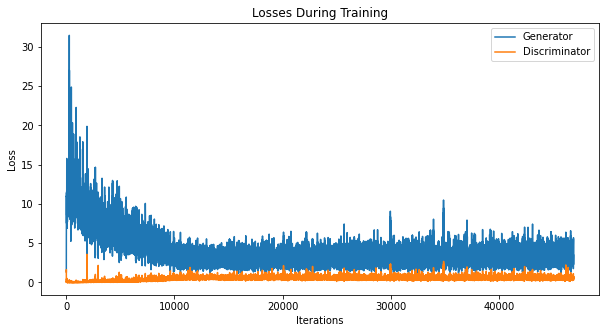

In [89]:
plt.figure(figsize = (10,5))
plt.title("Losses During Training")
plt.plot(gen_loss, label = "Generator")
plt.plot(d_loss,label = "Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

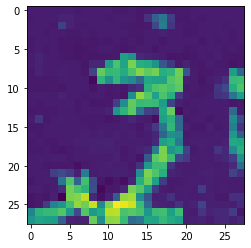

In [94]:
input = torch.randn(1,128,1,1,device = device)
img  = gen(input)

plt.figure()
plt.imshow(np.squeeze(img.detach().cpu().numpy()))
plt.show()

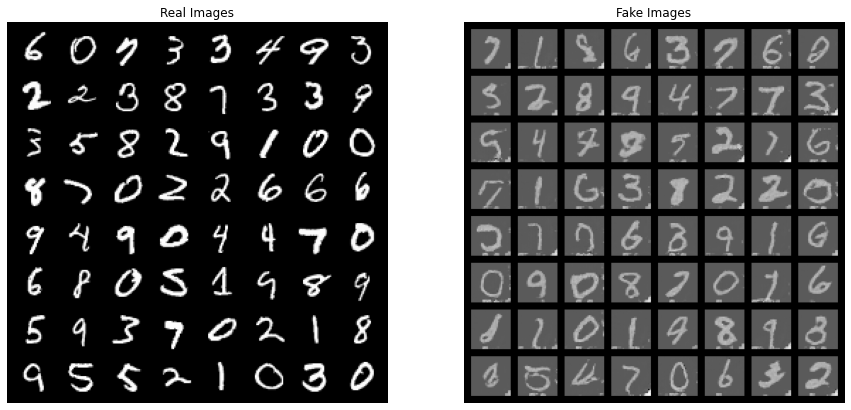

In [97]:
real_batch = next(iter(train_dataloader))
plt.figure(figsize = (15,15))
real_batch = real_batch[0].float().to(device)[:64].unsqueeze(1)
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
imageGrid = vutils.make_grid(real_batch, padding=5, normalize=True).cpu()
plt.imshow(imageGrid.permute(1,2,0))


fakeBatchNoise = torch.randn(64,128,1,1,device = device)
fakeImages = gen(fakeBatchNoise)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
fakeImageGrid = vutils.make_grid(fakeImages.to(device)[:64], padding=5, normalize=True).cpu()
plt.imshow(fakeImageGrid.permute(1,2,0))
plt.show()